# Sorting

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `Comparator`
Compare and potentially swaps two n-bit numbers.

Implements $U|a\rangle|b\rangle|0\rangle \rightarrow |\min(a,b)\rangle|\max(a,b)\rangle|a>b\rangle$,

where $a$ and $b$ are n-qubit quantum registers. On output a and b are
swapped if a > b. Forms the base primitive for sorting.

#### Parameters
 - `bitsize`: Number of bits used to represent each integer. 

#### Registers
 - `a`: A nbit-sized input register (register a above).
 - `b`: A nbit-sized input register (register b above).
 - `out`: A single bit output register which will store the result of the comparator. 

#### References
 - [Improved techniques for preparing eigenstates of fermionic Hamiltonians](https://www.nature.com/articles/s41534-018-0071-5). Fig. 1. in main text.


In [2]:
from qualtran.bloqs.arithmetic import Comparator

### Example Instances

In [3]:
n = sympy.Symbol('n')
cmp_symb = Comparator(bitsize=n)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([cmp_symb],
           ['`cmp_symb`'])

### Call Graph

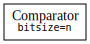

#### Counts totals:
 - `Comparator(bitsize=n)`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
cmp_symb_g, cmp_symb_sigma = cmp_symb.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(cmp_symb_g)
show_counts_sigma(cmp_symb_sigma)

## `BitonicSort`
Sort k n-bit numbers.

TODO: actually implement the algorithm using comparitor. Hiding ancilla cost
    for the moment. Issue #219

#### Parameters
 - `bitsize`: Number of bits used to represent each integer.
 - `k`: Number of integers to sort. 

#### Registers
 - `input`: List of k integers we want to sort. 

#### References
 - [Improved techniques for preparing eigenstates of fermionic Hamiltonians](https://www.nature.com/articles/s41534-018-0071-5). Supporting Information Sec. II.


In [6]:
from qualtran.bloqs.arithmetic import BitonicSort

### Example Instances

In [7]:
n = sympy.Symbol('n')
bitonic_sort = BitonicSort(bitsize=n, k=3)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([bitonic_sort],
           ['`bitonic_sort`'])

### Call Graph

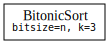

#### Counts totals:
 - `BitonicSort(bitsize=n, k=3)`: 1

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
bitonic_sort_g, bitonic_sort_sigma = bitonic_sort.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(bitonic_sort_g)
show_counts_sigma(bitonic_sort_sigma)